In [1]:
import mne
import numpy as np
import pandas as pd
import scipy.stats as stats
from itertools import product
import neurokit2 as nk
from pymatreader import read_mat
import time
from scipy.stats import iqr
from scipy.stats import shapiro
from mne import create_info
import seaborn as sns
import warnings
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from os import listdir
from os.path import isfile, join

from matplotlib import pyplot as plt

## Functions

In [72]:
def plot_values_topomap(value_dict, montage, axes, mask, mask_params, colorbar=True, cmap='PuOr',
                        vmin=None, vmax=None, names=None, image_interp='linear', side_cb="right",
                        sensors=True, show_names=True, format='%.2f', cbar_title='', **kwargs):
    if names is None:
        names = montage.ch_names

    info = create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(names), 1)), info, copy=None, verbose=False).set_montage(montage)

    im = plot_topomap([value_dict[ch] for ch in names], pos=info, show=False, image_interp=image_interp,
                      sensors=sensors, res=64, axes=axes, names=None, mask=mask, mask_params=mask_params, cmap=cmap, vlim=(vmin,vmax),**kwargs)

    if colorbar:
        try:
            cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                      format=format, side=side_cb)
            
            axes.cbar = cbar
            cbar.ax.tick_params(labelsize=14)
            cax.set_ylabel(cbar_title,fontsize=14)

        except TypeError:
            pass

    return im

In [3]:
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]

In [4]:
def get_channel_index_for_scale(cluster, scale):
    return cluster[:,cluster[1]==scale][0]

## Reading in the mse dataframe

In [73]:
mse = pd.read_csv(f'/Users/lina_01/Desktop/ab_ica/entropy_all_20_scales.csv')

In [74]:
#removing inf and NAME
mse = mse[mse['entropy'].astype(str).str.contains('inf')==False]
mse = mse[mse['entropy'].astype(str).str.contains('#NAME?')==False]
mse = mse.astype({'entropy':'float'})

In [75]:
#narrow down to eye movements
mse_saccade = mse.loc[mse['seg_type']=='saccade']

In [38]:
pt_list = mse_saccade['pt'].unique()

### Eye movement segments

### finding maximum scale

In [76]:
mse_saccade_original = mse_saccade.loc[(mse_saccade['seg_type']=='saccade')&(mse_saccade['kind']=='original')]
mse_saccade_ab = mse_saccade.loc[(mse_saccade['seg_type']=='saccade')&(mse_saccade['kind']=='AB')]
mse_saccade_ica = mse_saccade.loc[(mse_saccade['seg_type']=='saccade')&(mse_saccade['kind']=='ICA')]

mse_scales = []
for pt in pt_list:
    scales_original = list(mse_saccade_original.loc[mse_saccade_original['pt']==pt]['Scale'])
    mse_scales.append(scales_original)
    scales_ab = list(mse_saccade_ab.loc[mse_saccade_ab['pt']==pt]['Scale'])
    mse_scales.append(scales_ab)
    scales_ica = list(mse_saccade_ica.loc[mse_saccade_ica['pt']==pt]['Scale'])
    mse_scales.append(scales_ica)

scales_in_all = list(set.intersection(*map(set, mse_scales)))

In [40]:
scales_in_all

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

#### Calculating differences

In [77]:
tmp = mse_saccade.pivot_table(index = ["pt","channel","seg_type","Scale"], columns="kind",values="entropy")
original = tmp['original']
ab = tmp['AB']
ica = tmp['ICA']

diff_AB = (original - ab).abs()
diff_AB.name = "diff_mse"
diff_AB = diff_AB.reset_index()

diff_ICA = (original - ica).abs()
diff_ICA.name = "diff_mse"
diff_ICA = diff_ICA.reset_index()

#### Cluster-based permutation test

In [78]:
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
info = mne.create_info(montage.ch_names, sfreq=500, ch_types='eeg')
raw = mne.io.RawArray(np.zeros([129,1]), info).set_montage(montage)
channel_names = montage.ch_names

threshold = 434

adj_matrix = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')[0]
adj_matrix = mne.stats.combine_adjacency(adj_matrix, 20)

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 129


In [79]:
X_saccade_ab_ica = []
for scale in scales_in_all:
    mse_saccade_ica_array = diff_ICA.loc[diff_ICA['Scale']==scale]
    mse_saccade_ica_array = mse_saccade_ica_array.pivot_table(index='pt',columns='channel', values='diff_mse')
    mse_saccade_ica_array = np.array(mse_saccade_ica_array.loc[:,montage.ch_names])

    
    mse_saccade_ab_array = diff_AB.loc[diff_AB['Scale']==scale]
    mse_saccade_ab_array = mse_saccade_ab_array.pivot_table(index='pt',columns='channel', values='diff_mse')
    mse_saccade_ab_array = np.array(mse_saccade_ab_array.loc[:,montage.ch_names])
    
    X_saccade_ab_ica.append([mse_saccade_ica_array, mse_saccade_ab_array])

X_saccade_ab_ica = np.array(X_saccade_ab_ica).transpose([1,2,3,0])

In [80]:
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_saccade_ab_ica, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 23 clusters


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_3891/3455683580.py:1: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_saccade_ab_ica, threshold = 1/threshold, n_permutations=1000,


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

### Extracting significant channels to plot

In [81]:
chosen_scales = [2,10,20]

mask_dict = {}

for ind_scale, scale in enumerate(chosen_scales):
    significant_channels = []
    for cluster, p_val in zip(clusters, clusters_pv):   
        if p_val > 0.05:
            continue
        cluster = np.stack(cluster)
        channel_index = get_channel_index_for_scale(cluster, ind_scale)
        significant_channels.extend(channel_index)
        
    significant_channels = sorted(significant_channels)
    
    mask = np.zeros((129,),dtype='bool')
    for ch in significant_channels:
        mask[ch] = True
    mask_dict[scale] = mask

### Topomap differences calculation

In [82]:
diff_AB_ICA = (diff_AB.set_index(["pt", "channel", "seg_type", "Scale"]) - 
               diff_ICA.set_index(["pt", "channel", "seg_type", "Scale"])).reset_index()
diff_AB_ICA = diff_AB_ICA.drop(columns="pt").groupby(["channel", "seg_type", "Scale"]).mean()

dict_topomaps = {scale: df.reset_index(["seg_type", "Scale"])["diff_mse"].to_dict() 
                 for scale, df in diff_AB_ICA.groupby("Scale")}


In [83]:
mask_params = dict(markersize=5, markerfacecolor="y")

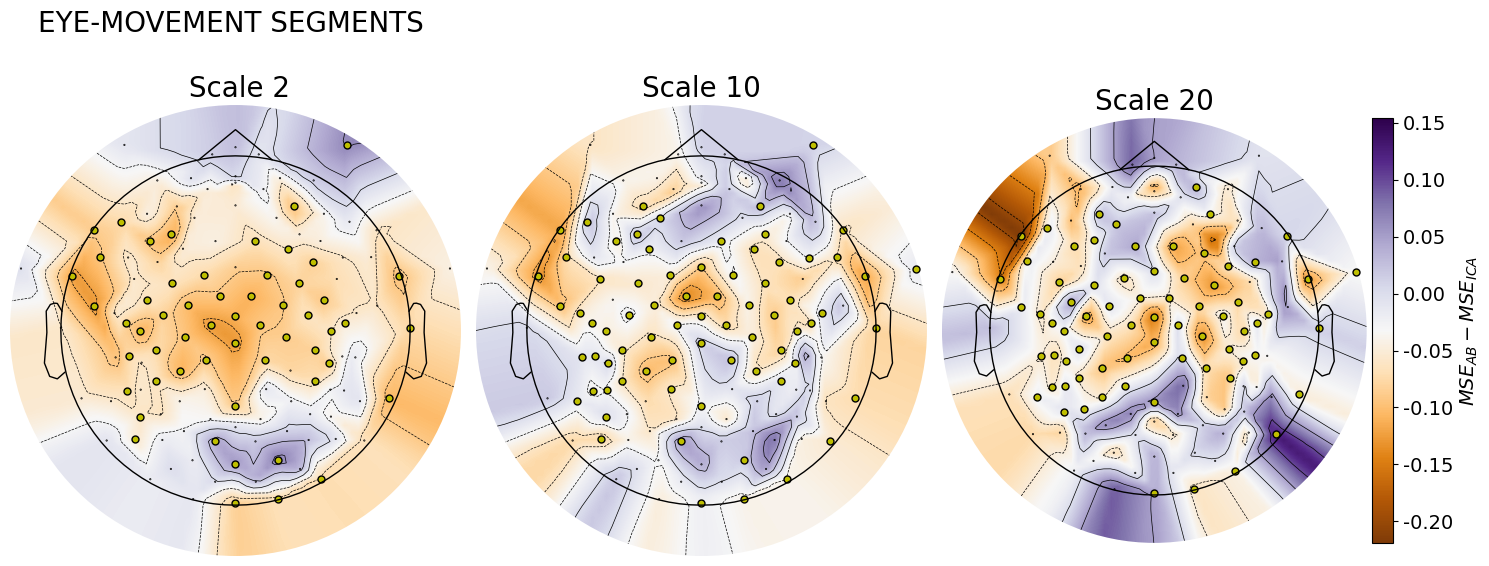

In [84]:
fig, axes = plt.subplots(1,3,figsize=(15,6))

vmins = []
vmaxes = []

for dict_topo in dict_topomaps.values():
    vmin = min(dict_topo.values())
    vmax = max(dict_topo.values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)


plot_values_topomap(dict_topomaps[2], montage, axes[0], mask_dict[2], mask_params, colorbar=False, vmin=vmin1, vmax=vmax1, names=channel_names)
plot_values_topomap(dict_topomaps[10], montage, axes[1], mask_dict[10], mask_params, colorbar=False, vmin=vmin1, vmax=vmax1, names=channel_names)
plot_values_topomap(dict_topomaps[20], montage, axes[2], mask_dict[20], mask_params, colorbar=True, vmin=vmin1, vmax=vmax1, names=channel_names, cbar_title='$MSE_{AB}-MSE_{ICA}$')

axes[0].set_title('EYE-MOVEMENT SEGMENTS \n \n Scale 2',fontsize=20)
axes[1].set_title('Scale 10',fontsize=20)
axes[2].set_title('Scale 20',fontsize=20)

fig.tight_layout()

plt.savefig('figS3a.png', facecolor='white',bbox_inches='tight')

## Clean segments

#### find maximum scale

In [85]:
mse_clean = mse.loc[mse['seg_type']=='clean']
mse_clean_original = mse_clean.loc[(mse_clean['seg_type']=='clean')&(mse_clean['kind']=='original')]
mse_clean_ab = mse_clean.loc[(mse_clean['seg_type']=='clean')&(mse_clean['kind']=='AB')]
mse_clean_ica = mse_clean.loc[(mse_clean['seg_type']=='clean')&(mse_clean['kind']=='ICA')]

mse_scales = []
for pt in pt_list:
    scales_original = list(mse_clean_original.loc[mse_clean_original['pt']==pt]['Scale'])
    mse_scales.append(scales_original)
    scales_ab = list(mse_clean_ab.loc[mse_clean_ab['pt']==pt]['Scale'])
    mse_scales.append(scales_ab)
    scales_ica = list(mse_clean_ica.loc[mse_clean_ica['pt']==pt]['Scale'])
    mse_scales.append(scales_ica)

scales_in_all = list(set.intersection(*map(set, mse_scales)))

In [86]:
scales_in_all

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

### Calculating differences

In [87]:
tmp = mse_clean.pivot_table(index = ["pt","channel","seg_type","Scale"], columns="kind",values="entropy")

In [88]:
tmp = mse_clean.pivot_table(index = ["pt","channel","seg_type","Scale"], columns="kind",values="entropy")
original = tmp['original']
ab = tmp['AB']
ica = tmp['ICA']

diff_AB = (original - ab).abs()
diff_AB.name = "diff_mse"
diff_AB = diff_AB.reset_index()

diff_ICA = (original - ica).abs()
diff_ICA.name = "diff_mse"
diff_ICA = diff_ICA.reset_index()

### Cluster based permutation test

In [89]:
X_clean_ab_ica = []
for scale in scales_in_all:
    mse_clean_ica_array = diff_ICA.loc[diff_ICA['Scale']==scale]
    mse_clean_ica_array = mse_clean_ica_array.pivot_table(index='pt',columns='channel', values='diff_mse')
    mse_clean_ica_array = np.array(mse_clean_ica_array.loc[:,montage.ch_names])

    
    mse_clean_ab_array = diff_AB.loc[diff_AB['Scale']==scale]
    mse_clean_ab_array = mse_clean_ab_array.pivot_table(index='pt',columns='channel', values='diff_mse')
    mse_clean_ab_array = np.array(mse_clean_ab_array.loc[:,montage.ch_names])
    
    X_clean_ab_ica.append([mse_clean_ica_array, mse_clean_ab_array])

X_clean_ab_ica = np.array(X_clean_ab_ica).transpose([1,2,3,0])

In [90]:
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_clean_ab_ica, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.001580 max=0.021739
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

### Extracting significant channels to plot

In [91]:
chosen_scales = [2,10,20]

mask_dict = {}

for ind_scale, scale in enumerate(chosen_scales):
    significant_channels = []
    for cluster, p_val in zip(clusters, clusters_pv):   
        if p_val > 0.05:
            continue
        cluster = np.stack(cluster)
        channel_index = get_channel_index_for_scale(cluster, ind_scale)
        significant_channels.extend(channel_index)
        
    significant_channels = sorted(significant_channels)
    
    mask = np.zeros((129,),dtype='bool')
    for ch in significant_channels:
        mask[ch] = True
    mask_dict[scale] = mask

### Topomap differences

In [92]:
diff_AB_ICA = (diff_AB.set_index(["pt", "channel", "seg_type", "Scale"]) - 
               diff_ICA.set_index(["pt", "channel", "seg_type", "Scale"])).reset_index()
diff_AB_ICA = diff_AB_ICA.drop(columns="pt").groupby(["channel", "seg_type", "Scale"]).mean()

dict_topomaps = {scale: df.reset_index(["seg_type", "Scale"])["diff_mse"].to_dict() 
                 for scale, df in diff_AB_ICA.groupby("Scale")}


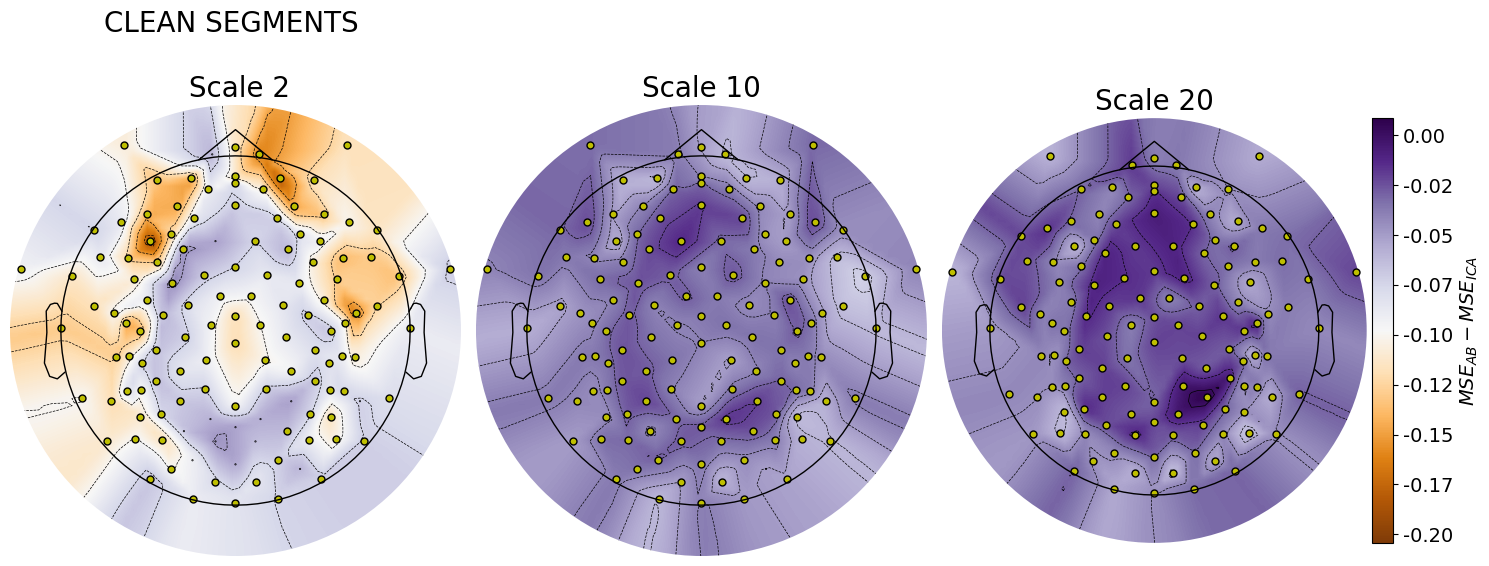

In [93]:
fig, axes = plt.subplots(1,3,figsize=(15,6))

vmins = []
vmaxes = []

for dict_topo in dict_topomaps.values():
    vmin = min(dict_topo.values())
    vmax = max(dict_topo.values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)


plot_values_topomap(dict_topomaps[2], montage, axes[0], mask_dict[2], mask_params, colorbar=False, vmin=vmin1, vmax=vmax1, names=channel_names)
plot_values_topomap(dict_topomaps[10], montage, axes[1], mask_dict[10], mask_params, colorbar=False, vmin=vmin1, vmax=vmax1, names=channel_names)
plot_values_topomap(dict_topomaps[20], montage, axes[2], mask_dict[20], mask_params, colorbar=True, vmin=vmin1, vmax=vmax1, names=channel_names, cbar_title='$MSE_{AB}-MSE_{ICA}$')

axes[0].set_title('CLEAN SEGMENTS \n \n Scale 2',fontsize=20)
axes[1].set_title('Scale 10',fontsize=20)
axes[2].set_title('Scale 20',fontsize=20)

fig.tight_layout()

plt.savefig('figS3b.png', facecolor='white',bbox_inches='tight')

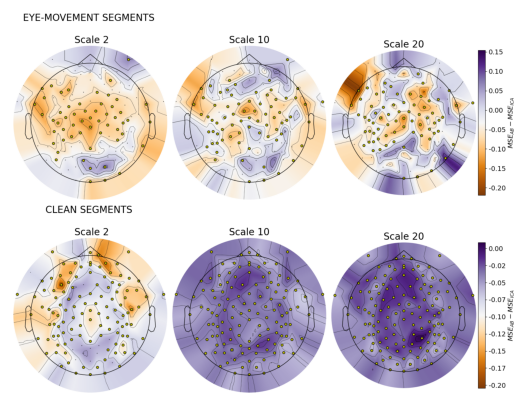

In [94]:
import matplotlib.image as mpimg
figures = ['S3a','S3b']
margin = 200
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
for figure, ax in zip(figures, axes.ravel()):
    img = mpimg.imread(f"/Users/lina_01/Desktop/ab_ica/fig{figure}.png")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(frame_on=False)
    
    ax.imshow(img)        
    ax.set_aspect(1)    
    
fig.tight_layout(rect=[-0.01, -0.02, 1.02, 1.02], w_pad=0.0, h_pad=0.0)
fig.savefig("figS3.png", dpi=300)